# GCバックテストノートブック

GC戦略（SMA30/60ゴールデンクロス）で取得したローソク足を読み込み、`gc_bot` のバックテストユーティリティを使って検証する。

In [1]:
import json
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, List, Optional

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

from gc_bot import (
    BacktestConfig,
    BacktestResult,
    BacktestTrade,
    OrderParams,
    SignalParams,
    add_sma_columns,
    run_backtest,
)


## データロード用ヘルパー

In [2]:
def load_cached_ohlcv(
    log_dir: Path = Path("../data/candles/logs"),
    limit_files: Optional[int] = None,
) -> pd.DataFrame:
    """指定ディレクトリから1時間足ログCSVを読み込み、結合して返す。"""
    if isinstance(log_dir, str):
        log_dir = Path(log_dir)
    csv_paths = sorted(log_dir.glob("xrpjpy_1h_*.csv"))
    if not csv_paths:
        raise FileNotFoundError(f"No CSV files found under {log_dir}")
    if limit_files is not None:
        csv_paths = csv_paths[-limit_files:]
    frames: List[pd.DataFrame] = []
    for path in csv_paths:
        df = pd.read_csv(
            path,
            parse_dates=["open_time_jst", "close_time_jst"],
            index_col="close_time_jst",
        )
        frames.append(df[["open", "high", "low", "close", "volume"]])
    merged = pd.concat(frames)
    merged = merged[~merged.index.duplicated(keep="last")]
    merged = merged.sort_index()
    return merged


## バックテスト実行を関数化

In [3]:
def run_gc_backtest(
    df_ohlcv: pd.DataFrame,
    signal_params: Optional[SignalParams] = None,
    order_params: Optional[OrderParams] = None,
    **backtest_kwargs: Any,
) -> BacktestResult:
    """データフレームとパラメータを受け取ってGCバックテストを実行する。"""
    cfg = BacktestConfig(
        signal=signal_params or SignalParams(),
        order=order_params or OrderParams(),
        **backtest_kwargs,
    )
    return run_backtest(df_ohlcv, cfg)


## ローソク足 + トレード描画ヘルパー

In [4]:
def plot_candles_with_trades(
    df_plot: pd.DataFrame,
    trades: List[BacktestTrade],
    title: str = "Candlestick with trades",
    max_trades: Optional[int] = None,
) -> None:
    """df_plot のローソク足チャートにエントリー/イグジットを重ねて表示する。"""
    if df_plot.empty:
        raise ValueError("df_plot is empty")

    idx = df_plot.index
    if isinstance(idx, pd.DatetimeIndex) and idx.tz is not None:
        idx = idx.tz_convert(None)
    dates = mdates.date2num(idx.to_pydatetime())

    opens = df_plot['open'].values
    highs = df_plot['high'].values
    lows = df_plot['low'].values
    closes = df_plot['close'].values

    if len(dates) > 1:
        spacing = np.min(np.diff(dates))
        half = (spacing if spacing > 0 else 0.02) * 0.4
    else:
        half = 0.02

    fig, ax = plt.subplots(figsize=(12, 6))
    for d, o, h, l, c in zip(dates, opens, highs, lows, closes):
        color = 'tab:red' if c >= o else 'tab:blue'
        ax.vlines(d, l, h, color=color, linewidth=1)
        ax.hlines(o, d - half, d, color=color, linewidth=3)
        ax.hlines(c, d, d + half, color=color, linewidth=3)

    def _to_num(ts):
        ts = pd.to_datetime(ts)
        if ts.tz is not None:
            ts = ts.tz_convert(None)
        return mdates.date2num(ts.to_pydatetime())

    entry_label = False
    exit_label = False
    start, end = dates[0], dates[-1]

    for trade in trades[: max_trades or len(trades)]:
        entry_num = _to_num(trade.entry_ts)
        exit_num = _to_num(trade.exit_ts)

        if start <= entry_num <= end:
            ax.scatter(entry_num, trade.entry_price, marker='^', s=90, color='green', edgecolor='black', label='Entry' if not entry_label else '')
            entry_label = True
        if start <= exit_num <= end:
            ax.scatter(exit_num, trade.exit_price, marker='v', s=90, color='orange', edgecolor='black', label='Exit' if not exit_label else '')
            exit_label = True

    ax.set_title(title)
    ax.set_ylabel('Price (JPY)')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d%H:%M'))
    fig.autofmt_xdate()
    ax.grid(True, alpha=0.2)

    if 'sma_short' in df_plot.columns:
        ax.plot(dates, df_plot['sma_short'].values, color='gold', linewidth=1.5, label='SMA Short')
    if 'sma_long' in df_plot.columns:
        ax.plot(dates, df_plot['sma_long'].values, color='purple', linewidth=1.5, label='SMA Long')

    handles, labels = ax.get_legend_handles_labels()
    if any(labels):
        ax.legend()

    plt.show()


## データを読み込む

In [5]:
# 直近のCSV 200ファイルを読み込む例（必要に応じてNoneにして全量読み込み）
df = load_cached_ohlcv(limit_files=200)
print(df.shape)
df.tail()


(370, 5)


,open,high,low,close,volume
close_time_jst,,,,,
2025-10-05 12:00:00+09:00,443.80,446.86,443.21,444.25,159827.4
2025-10-05 13:00:00+09:00,444.25,449.12,443.70,447.72,206722.3
2025-10-05 14:00:00+09:00,447.81,449.00,446.36,447.70,89151.5
2025-10-05 15:00:00+09:00,447.73,448.64,446.57,447.34,75510.0
2025-10-05 16:00:00+09:00,447.52,452.16,447.31,451.88,69244.6


## パラメータ設定

In [6]:
signal_params = SignalParams(short_window=30, long_window=60, epsilon=1e-12)
order_params = OrderParams(
    mode="paper",
    notional_jpy=5000.0,
    slippage_bps=5.0,
    taker_fee_bps=15.0,
)

initial_capital = 1_000_000.0  # 総資金（例）
notional_fraction = 0.05       # 1トレードあたり総資金に対する割合


## 移動平均を付与したデータセット

In [7]:
df_with_ma = add_sma_columns(df.copy(), signal_params)
df_with_ma.tail()

,open,high,low,close,volume,sma_short,sma_long
close_time_jst,,,,,,,
2025-10-05 12:00:00+09:00,443.80,446.86,443.21,444.25,159827.4,441.693000,445.151833
2025-10-05 13:00:00+09:00,444.25,449.12,443.70,447.72,206722.3,441.641000,445.143000
2025-10-05 14:00:00+09:00,447.81,449.00,446.36,447.70,89151.5,441.617667,445.154833
2025-10-05 15:00:00+09:00,447.73,448.64,446.57,447.34,75510.0,441.569667,445.093667
2025-10-05 16:00:00+09:00,447.52,452.16,447.31,451.88,69244.6,441.765667,445.043000


## バックテスト実行

In [8]:
result = run_gc_backtest(
    df_with_ma,
    signal_params=signal_params,
    order_params=order_params,
    initial_capital=initial_capital,
    notional_fraction=notional_fraction,
)
summary = result.summary
summary

{'trades': 3,
 'win': 3,
 'loss': 0,
 'win_rate': 100.0,
 'pnl_total': 2472.38,
 'pnl_per_trade': 824.13,
 'max_drawdown': 0.0,
 'max_drawdown_pct': 0.0,
 'capital_initial': 1000000.0,
 'capital_final': 1002472.38,
 'total_return_pct': 0.25,
 'sharpe_ratio': 584298657577740.5,
 'mean_trade_return': 0.0165,
 'trade_return_std': 0.0,
 'notional_fraction': 0.05,
 'notional_static': 5000.0}

## 主要バックテスト指標

In [9]:
print(f"Total Return: {summary['total_return_pct']} %")
print(f"Max Drawdown: {summary['max_drawdown']} JPY ({summary['max_drawdown_pct']} %)")
print(f"Sharpe Ratio: {summary['sharpe_ratio']}")


Total Return: 0.25 %
Max Drawdown: 0.0 JPY (0.0 %)
Sharpe Ratio: 584298657577740.5


## トレード詳細

In [10]:
trades_df = pd.DataFrame([trade.to_dict() for trade in result.trades])
trades_df.head()


,entry_ts,exit_ts,entry_price,exit_price,size,pnl_jpy,reason,duration_bars,entry_fee_jpy,exit_fee_jpy,notional_jpy
0,2025-09-24T20:00:00+09:00,2025-09-25T00:00:00+09:00,428.704245,437.059691,116.688838,823.449769,TP,4,75.03750,76.499981,50000.000000
1,2025-09-28T04:00:00+09:00,2025-09-29T07:00:00+09:00,418.239015,426.390493,119.707132,824.127839,TP,27,75.09929,76.562975,50041.172488
2,2025-10-02T08:00:00+09:00,2025-10-03T01:00:00+09:00,434.136960,442.598289,115.418462,824.806467,TP,17,75.16113,76.626021,50082.378880


## ローソク足 + エントリー/イグジット表示

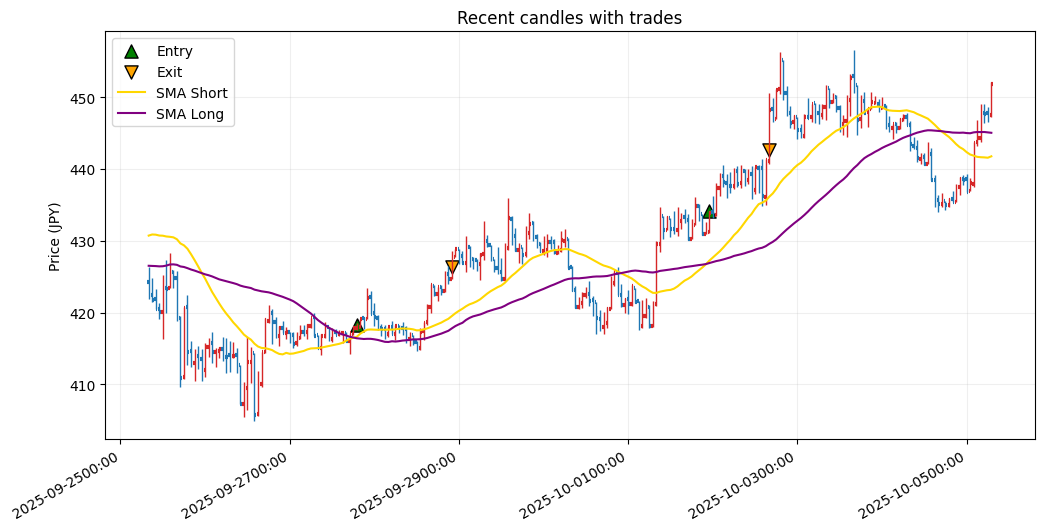

In [11]:
# 直近240本を対象にローソク足とトレードタイミングを重ねて表示
plot_candles_with_trades(df_with_ma.tail(240), result.trades, title="Recent candles with trades")


## エクイティカーブ

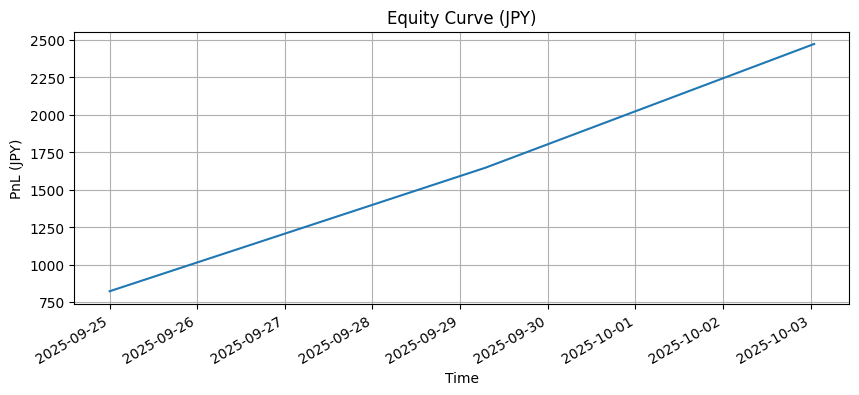

In [12]:
%matplotlib inline
plt.figure(figsize=(10, 4))
result.equity_curve.plot()
plt.title("Equity Curve (JPY)")
plt.ylabel("PnL (JPY)")
plt.xlabel("Time")
plt.grid(True)
plt.show()


## まとめ
- `load_cached_ohlcv()` で既存ログを結合。
- `run_gc_backtest()` でゴールデンクロス戦略のバックテストを実行。
- `result.summary` / `result.trades` / `result.equity_curve` から統計を確認。

パラメータを変更しながら繰り返し検証できる。